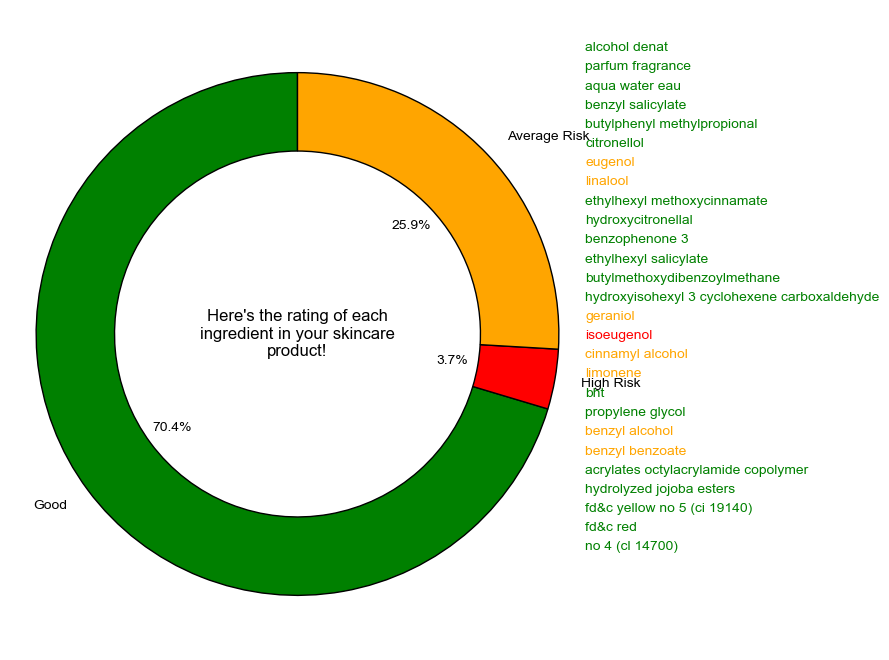

In [3]:
import json
import torch
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

class IngredientsAnalyzer:
    def __init__(self, model_path="data/model/ingredient_word2vec.model"):
        """Initialize the analyzer with ingredient lists and word embeddings model."""
        self.word2vec_model = self.load_ingredient_model(model_path)
        self.concern_chems, self.red_list, self.the_gens = self.load_ingredient_lists()

    def load_ingredient_model(self, model_path):
        """Load the trained Word2Vec model."""
        try:
            return Word2Vec.load(model_path)
        except FileNotFoundError:
            print(f"Warning: Model not found at {model_path}.")
            return None

    def load_ingredient_lists(self):
        """Load concern chemicals, red list, and allergens lists."""
        concern_chems = []
        red_list = []
        the_gens = []  # allergens

        try:
            with open("data/concern_chems.txt") as f:
                concern_chems = [self.normalize_ingredient(line.strip()) for line in f]
        except FileNotFoundError:
            print("Warning: concern_chems.txt not found. Using empty list.")

        try:
            with open("data/red_list.txt") as f:
                red_list = [self.normalize_ingredient(line.strip()) for line in f]
        except FileNotFoundError:
            print("Warning: red_list.txt not found. Using empty list.")

        try:
            with open("data/the_gens.txt") as f:
                the_gens = [self.normalize_ingredient(line.strip()) for line in f]
        except FileNotFoundError:
            print("Warning: the_gens.txt not found. Using empty list.")

        return concern_chems, red_list, the_gens

    def get_ingredients(self, ingredients_str):
        """
        Extract and normalize ingredients from a string.

        Args:
            ingredients_str: String containing ingredient list

        Returns:
            List of normalized ingredient strings
        """
        return self.split_and_normalize_ingredients([ingredients_str])

    def normalize_ingredient(self, ingredient):
        """
        Normalize a single ingredient name.

        Args:
            ingredient: An ingredient string

        Returns:
            Normalized ingredient string
        """
        if not isinstance(ingredient, str):
            ingredient = str(ingredient)
        ingredient = ingredient.lower()  # Convert to lowercase
        ingredient = re.sub(r'[-.,/]+', ' ', ingredient)  # Replace separators with space
        ingredient = re.sub(r'\s+', ' ', ingredient).strip()  # Remove extra spaces
        return ingredient

    def split_and_normalize_ingredients(self, ingredients_list):
        """
        Split and normalize a list of ingredient strings.

        Args:
            ingredients_list: List of strings containing ingredients

        Returns:
            List of normalized ingredient strings
        """
        all_ingredients = []
        if isinstance(ingredients_list, str):
            ingredients_list = [ingredients_list]

        for ingredients_str in ingredients_list:
            if not isinstance(ingredients_str, str):
                continue
            # Split by commas while preserving items with parentheses
            ingredients = re.split(r',\s*(?![^()]*\))', ingredients_str)
            # Normalize each ingredient
            normalized_ingredients = [self.normalize_ingredient(ingredient) for ingredient in ingredients]
            all_ingredients.extend(normalized_ingredients)
        return all_ingredients

    def get_sentence_vector(self, sentence):
        """
        Create a vector representation of a sentence using the word2vec model.

        Args:
            sentence: List of words

        Returns:
            numpy array of the sentence embedding
        """
        vectors = [self.word2vec_model.wv[word] for word in sentence if word in self.word2vec_model.wv]
        if vectors:
            return np.mean(vectors, axis=0)  # Take the average of word vectors
        else:
            return np.zeros(self.word2vec_model.vector_size)

    def analyze_ingredients(self, ingredients_str):
        """
        Analyze a list of ingredients for safety and concerns.

        Args:
            ingredients_str: String containing ingredient list

        Returns:
            Dictionary with analysis results
        """
        # Get normalized ingredients
        normalized_ingredients = self.get_ingredients(ingredients_str)

        # Generate embedding
        tokens = simple_preprocess(ingredients_str)
        embedding = self.get_sentence_vector(tokens).reshape(1, -1)

        # Find matches with concern lists
        red_list_include = []
        the_gens_include = []
        concern_chems_include = []

        # Check against red list (high risk)
        for i in normalized_ingredients:
            for j in self.red_list:
                if i == j and j not in red_list_include:
                    red_list_include.append(j)

        # Check against allergens (average risk)
        for i in normalized_ingredients:
            for j in self.the_gens:
                if i == j and j not in red_list_include and j not in the_gens_include:
                    the_gens_include.append(j)

        # Check against concern chemicals (low risk)
        for i in normalized_ingredients:
            for j in self.concern_chems:
                if (i == j and j not in red_list_include and
                    j not in the_gens_include and j not in concern_chems_include):
                    concern_chems_include.append(j)

        # Count safe ingredients
        good_ingredients = [ing for ing in normalized_ingredients
                           if ing not in red_list_include and
                              ing not in the_gens_include and
                              ing not in concern_chems_include]

        # Create analysis result
        result = {
            "all_ingredients": normalized_ingredients,
            "good_ingredients": good_ingredients,
            "red_list_ingredients": red_list_include,
            "allergen_ingredients": the_gens_include,
            "concern_ingredients": concern_chems_include,
            "embedding": embedding,
            "counts": {
                "good": len(good_ingredients),
                "high_risk": len(red_list_include),
                "average_risk": len(the_gens_include),
                "low_risk": len(concern_chems_include),
                "total": len(normalized_ingredients)
            }
        }

        return result

    def visualize_ingredients(self, ingredients_str=None, analysis_result=None):
        """
        Visualize ingredient analysis with a donut chart.

        Args:
            ingredients_str: String containing ingredient list (optional if analysis_result provided)
            analysis_result: Pre-computed analysis result (optional if ingredients_str provided)

        Returns:
            Matplotlib figure
        """
        if analysis_result is None and ingredients_str is not None:
            analysis_result = self.analyze_ingredients(ingredients_str)
        elif analysis_result is None and ingredients_str is None:
            raise ValueError("Either ingredients_str or analysis_result must be provided")

        # Extract counts
        good_count = analysis_result["counts"]["good"]
        high_risk_count = analysis_result["counts"]["high_risk"]
        average_risk_count = analysis_result["counts"]["average_risk"]
        low_risk_count = analysis_result["counts"]["low_risk"]

        # Filter out zero-value categories
        chart_data = []
        labels = []
        colors = []

        if good_count > 0:
            chart_data.append(good_count)
            labels.append('Good')
            colors.append('green')
        if high_risk_count > 0:
            chart_data.append(high_risk_count)
            labels.append('High Risk')
            colors.append('red')
        if average_risk_count > 0:
            chart_data.append(average_risk_count)
            labels.append('Average Risk')
            colors.append('orange')
        if low_risk_count > 0:
            chart_data.append(low_risk_count)
            labels.append('Low Risk')
            colors.append('yellow')

        # Create visualization
        fig, ax = plt.subplots(figsize=(10, 8))

        # Donut chart parameters
        wedgeprops = {'width': 0.3, 'edgecolor': 'black'}  # Adjust width for hole size
        center_circle = Circle((0, 0), 0.4, color='white')  # Circle in the center
        ax.add_artist(center_circle)

        # Create the pie chart (with the "donut" hole)
        if chart_data:
            wedges, texts, autotexts = ax.pie(
                chart_data,
                autopct='%1.1f%%',
                startangle=90,
                colors=colors,
                labels=labels,
                wedgeprops=wedgeprops,
                textprops={'color': 'black'}
            )

            # Equal aspect ratio ensures that pie is drawn as a circle
            ax.axis('equal')

            # Add title inside the donut hole
            ax.text(
                0, 0,
                "Here's the rating of each\ningredient in your skincare\nproduct!",
                ha='center',
                va='center',
                fontsize=12,
                color='black'
            )

            # Add ingredient list with color coding (right side)
            fig.subplots_adjust(right=0.7)  # Adjust right margin for ingredient list
            ax2 = fig.add_axes([0.7, 0.1, 0.25, 0.8])  # left, bottom, width, height
            ax2.axis('off')  # hide axis

            # Collect ingredients for display with correct colors
            ingredients_to_display = []
            for ing in analysis_result["all_ingredients"]:
                if ing in analysis_result["red_list_ingredients"]:
                    ingredients_to_display.append((ing, 'red'))
                elif ing in analysis_result["allergen_ingredients"]:
                    ingredients_to_display.append((ing, 'orange'))
                elif ing in analysis_result["concern_ingredients"]:
                    ingredients_to_display.append((ing, 'yellow'))
                else:
                    ingredients_to_display.append((ing, 'green'))

            # Display ingredients with color coding
            y_pos = 0.95
            for ing, color in ingredients_to_display:
                ax2.text(0, y_pos, ing, color=color, fontsize=10, va='top')
                y_pos -= 0.03  # Adjust spacing as needed

        return fig

# Example usage
if __name__ == "__main__":
    # Example ingredient list
    example_ingredients = r"Alcohol Denat., Parfum/Fragrance, Aqua/Water/Eau, Benzyl Salicylate, Butylphenyl Methylpropional, Citronellol, Eugenol, Linalool, Ethylhexyl Methoxycinnamate, Hydroxycitronellal, Benzophenone-3, Ethylhexyl Salicylate, Butylmethoxydibenzoylmethane, Hydroxyisohexyl 3-Cyclohexene Carboxaldehyde, Geraniol, Isoeugenol, Cinnamyl Alcohol, Limonene, Bht, Propylene Glycol, Benzyl Alcohol, Benzyl Benzoate, Acrylates/Octylacrylamide Copolymer, Hydrolyzed Jojoba Esters, Fd&C Yellow No. 5 (Ci 19140), Fd&C Red, No. 4 (Cl 14700)."

    # Initialize analyzer
    analyzer = IngredientsAnalyzer()

    # Analyze and visualize ingredients
    result = analyzer.analyze_ingredients(example_ingredients)
    fig = analyzer.visualize_ingredients(analysis_result=result)
    plt.show()

In [4]:
import joblib
from torch.nn.functional import cosine_similarity
from ingredients_analyzer import IngredientsAnalyzer


def normalize_ingredient(ingredient):
    """Normalize ingredient names for consistent comparison"""
    if not isinstance(ingredient, str):
        ingredient = str(ingredient)
    ingredient = ingredient.lower()  # Convert to lowercase
    ingredient = re.sub(r'[-.,/]+', ' ', ingredient)  # Replace separators with space
    ingredient = re.sub(r'\s+', ' ', ingredient).strip()  # Remove extra spaces
    return ingredient


######################################################################################################

def load_product_data(filepath="data/new_product_info3.csv"):
    """
    Load product data from CSV file and process embedding columns.

    Args:
        filepath: Path to CSV file containing product data

    Returns:
        Pandas DataFrame with processed data
    """
    data = pd.read_csv(filepath)

    # Convert JSON string representations back to NumPy arrays
    embedding_columns = ["ingredients_embedding", "concern_chems_embedding", "red_list_embedding", "the_gens_embedding"]
    for col in embedding_columns:
        if col in data.columns:
            data[col] = data[col].apply(lambda x: np.array(json.loads(x)) if not pd.isna(x) else np.zeros(100))

    # Process ingredient lists
    for col in ["concerning_chems_detected", "red_list_chems_detected", "allergens_detected"]:
        if col not in data.columns:
            data[col] = [[] for _ in range(len(data))]
        else:
            # Apply the safe processing function
            data[col] = data[col].apply(safe_process_ingredients)

    return data


def compute_similarity(input_emb, product_emb):
    """
    Compute cosine similarity between two embeddings.
    """
    try:
        # Convert numpy arrays to tensors
        if isinstance(input_emb, np.ndarray):
            input_emb = torch.tensor(input_emb, dtype=torch.float32)
        if isinstance(product_emb, np.ndarray):
            product_emb = torch.tensor(product_emb, dtype=torch.float32)

        # Ensure 1D by flattening if needed
        if len(input_emb.shape) > 1:
            input_emb = input_emb.flatten()
        if len(product_emb.shape) > 1:
            product_emb = product_emb.flatten()

        # Match dimensions if different lengths
        if input_emb.shape[0] != product_emb.shape[0]:
            min_len = min(input_emb.shape[0], product_emb.shape[0])
            input_emb = input_emb[:min_len]
            product_emb = product_emb[:min_len]

        return cosine_similarity(input_emb.unsqueeze(0), product_emb.unsqueeze(0)).item()
    except Exception:
        return 0.0


def safe_process_ingredients(item):
    """
    Safely process ingredient lists avoiding pd.isna() issues.
    """
    # Handle None values
    if item is None:
        return []

    # Check if it's already a list
    if isinstance(item, list):
        # Process each element to handle potential nested lists
        result = []
        for elem in item:
            if isinstance(elem, str):
                # Check if the string looks like a list representation
                if elem.strip().startswith('[') and elem.strip().endswith(']'):
                    try:
                        # Try different parsing methods
                        try:
                            # First try JSON parsing with proper quote replacement
                            parsed = json.loads(elem.replace("'", '"'))
                            if isinstance(parsed, list):
                                result.extend(parsed)
                            else:
                                result.append(parsed)
                        except:
                            # Then try ast.literal_eval
                            import ast
                            try:
                                parsed = ast.literal_eval(elem)
                                if isinstance(parsed, list):
                                    result.extend(parsed)
                                else:
                                    result.append(parsed)
                            except:
                                # If all parsing fails, keep the original string
                                result.append(elem)
                    except:
                        result.append(elem)
                else:
                    # Not a list representation, keep as is
                    result.append(elem)
            elif isinstance(elem, list):
                # Flatten nested lists
                result.extend(elem)
            else:
                # Keep other types as is
                result.append(elem)
        return result

    # Handle string values
    if isinstance(item, str):
        if not item or item == '[]':
            return []

        # Check if it's a JSON-like string representation of a list
        if item.strip().startswith('[') and item.strip().endswith(']'):
            try:
                # Try to parse as JSON with proper quote replacement
                parsed = json.loads(item.replace("'", '"'))
                if isinstance(parsed, list):
                    return parsed
                return [parsed]
            except:
                # Try with ast.literal_eval if JSON parsing fails
                try:
                    import ast
                    parsed = ast.literal_eval(item)
                    if isinstance(parsed, list):
                        return parsed
                    return [parsed]
                except:
                    # If all parsing fails, treat as a single item
                    return [item]

        # Handle comma-separated strings
        if ',' in item:
            return [x.strip() for x in item.split(',')]

        # Single value string
        return [item]

    # For any other type, try to convert to a list or return empty list
    try:
        return list(item)
    except:
        return []


def safe_len(x):
    """Helper function to safely get the length of a list."""
    if isinstance(x, list):
        return len(x)
    return 0


def format_list(ingredients):
    """
    Format a list of ingredients for display.
    """
    if ingredients is None:
        return "None detected"

    # Ensure we have a flat list of strings
    flat_list = []
    if isinstance(ingredients, list):
        for item in ingredients:
            if isinstance(item, list):
                flat_list.extend(str(x) for x in item)
            else:
                flat_list.append(str(item))

        if len(flat_list) > 0:
            # Remove any quotes from strings
            clean_list = [item.strip('"\'') for item in flat_list]
            return ", ".join(clean_list)
        else:
            return "None detected"

    # Handle string input
    elif isinstance(ingredients, str):
        return ingredients if ingredients else "None detected"

    return "None detected"


def has_matching_unsafe_ingredients(product_concern, product_allergens, product_red_list,
                                   concern_chems_include, the_gens_include, red_list_include):
    """
    Check if product contains any of the user's input unsafe ingredients.
    """
    # Using normalize_ingredient imported from ingredients_analyzer
    normalized_product_concern = [normalize_ingredient(str(item)) for item in product_concern]
    normalized_product_allergens = [normalize_ingredient(str(item)) for item in product_allergens]
    normalized_product_red_list = [normalize_ingredient(str(item)) for item in product_red_list]

    # Check if any input concerning chemicals match product's concerning chemicals
    for item in concern_chems_include:
        if item in normalized_product_concern:
            return True

    # Check if any input allergens match product's allergens
    for item in the_gens_include:
        if item in normalized_product_allergens:
            return True

    # Check if any input red list ingredients match product's red list
    for item in red_list_include:
        if item in normalized_product_red_list:
            return True

    return False


def calculate_similarity_score(input_embedding, filtered_data,
                              concern_chems_include, the_gens_include, red_list_include):
    """
    Calculate similarity scores between input embedding and product data.
    """
    # Ensure input_embedding is 1D
    if isinstance(input_embedding, np.ndarray) and len(input_embedding.shape) > 1 and input_embedding.shape[0] == 1:
        input_embedding = input_embedding.flatten()

    # Create a copy to avoid modifying the original dataframe
    scored_data = filtered_data.copy()

    # Calculate similarity for ingredients using embeddings
    scored_data["ingredient_similarity"] = scored_data["ingredients_embedding"].apply(
        lambda x: compute_similarity(input_embedding, x)
    )

    # Calculate penalty scores based on concerning ingredients
    scored_data["concerning_chems_score"] = scored_data["concerning_chems_detected"].apply(
        lambda x: 0.02 * safe_len(x)
    )
    scored_data["red_list_score"] = scored_data["red_list_chems_detected"].apply(
        lambda x: 0.1 * safe_len(x)
    )
    scored_data["allergens_score"] = scored_data["allergens_detected"].apply(
        lambda x: 0.04 * safe_len(x)
    )

    # Calculate final score - using embedding similarity minus penalties
    scored_data["final_score"] = scored_data.apply(
        lambda row: row["ingredient_similarity"] - row["concerning_chems_score"]
                    - row["red_list_score"] - row["allergens_score"],
        axis=1
    )

    # Filter out products with matching unsafe ingredients and low scores
    filtered_products = []
    eliminated_count = 0
    low_score_count = 0  # Track products eliminated due to low scores

    for idx, product in scored_data.iterrows():
        unsafe = has_matching_unsafe_ingredients(
            product.get('concerning_chems_detected', []),
            product.get('allergens_detected', []),
            product.get('red_list_chems_detected', []),
            concern_chems_include, the_gens_include, red_list_include
        )

        # Check for unsafe ingredients AND low score
        if unsafe:
            eliminated_count += 1
        elif product["final_score"] < 0.9:  # Check if score is too low
            low_score_count += 1
        else:
            filtered_products.append(product)

    # Convert filtered products list back to DataFrame for sorting
    if filtered_products:
        safe_products_df = pd.DataFrame(filtered_products)
        return safe_products_df, eliminated_count, low_score_count
    else:
        return pd.DataFrame(), eliminated_count, low_score_count


def predict_category(input_embedding, model_path="data/model/new_random_forest.pkl"):
    """
    Predict the category of a product based on its embedding.
    """
    try:
        # Load the saved model
        classifier = joblib.load(model_path)

        # Reshape input embedding if needed
        if len(input_embedding.shape) == 1:
            input_embedding = input_embedding.reshape(1, -1)

        # Predict the category
        predicted_category = classifier.predict(input_embedding)
        return predicted_category[0]
    except Exception as e:
        print(f"Error predicting category: {e}")
        return "Unknown"


def get_recommendation(input_embedding, primary_category=None, selected_tertiary=None,
                      concern_chems_include=[], the_gens_include=[], red_list_include=[],
                      data=None, model_path="data/model/new_random_forest.pkl"):
    """
    Get product recommendations based on input embedding and filters.
    """
    # Define category mapping
    tertiary_categories_map = {
        "Skincare": [
            "Anti-Aging", "BB & CC Cream", "Blemish & Acne Treatments", "Body Sunscreen",
            "Exfoliators", "Eye Creams & Treatments", "Eye Masks", "Face Masks",
            "Face Oils", "Face Serums", "Face Sunscreen", "Face Wash & Cleansers",
            "Facial Peels", "For Body", "For Face", "Mists & Essences",
            "Moisturizers", "Night Creams", "Sheet Masks", "Toners"
        ],
        "Makeup": [
            "Blush", "Bronzer", "Cheek Palettes", "Color Correct",
            "Concealer", "Contour", "Eye Palettes", "Eye Primer",
            "Eye Sets", "Eyebrow", "Eyeliner", "Eyeshadow",
            "Face Primer", "Face Sets", "False Eyelashes", "Foundation",
            "Highlighter", "Lip Balm & Treatment", "Lip Gloss", "Lip Liner",
            "Lip Plumper", "Lip Sets", "Lipstick", "Liquid Lipstick",
            "Makeup Removers", "Mascara", "Setting Spray & Powder", "Tinted Moisturizer"
        ],
        "Hair": [
            "Conditioner", "Dry Shampoo", "Hair Masks", "Hair Oil",
            "Hair Primers", "Hair Spray", "Hair Styling Products",
            "Leave-In Conditioner", "Scalp Treatments", "Shampoo"
        ],
        "Fragrance": [
            "Body Mist & Hair Mist", "Cologne", "Perfume", "Rollerballs & Travel Size"
        ]
    }

    # Load data if not provided
    if data is None:
        data = load_product_data()

    # Predict category if not provided
    if primary_category is None:
        primary_category = predict_category(input_embedding, model_path)

    # Check if category is valid and has available tertiary categories
    if primary_category == "Other" or primary_category not in tertiary_categories_map:
        return {
            "status": "error",
            "message": "No recommendations available for this category.",
            "primary_category": primary_category,
            "recommendations": []
        }

    # Get available tertiary categories
    available_tertiary = tertiary_categories_map.get(primary_category, [])

    # If no tertiary categories selected, use all
    if not selected_tertiary:
        selected_tertiary = available_tertiary

    # Filter data by primary category and selected tertiary categories
    filtered_data = data[
        (data["primary_category"] == primary_category) &
        (data["tertiary_category"].isin(selected_tertiary))
    ].copy()

    if len(filtered_data) == 0:
        return {
            "status": "error",
            "message": "No products found in these categories. Try different categories.",
            "primary_category": primary_category,
            "selected_tertiary": selected_tertiary,
            "recommendations": []
        }

    # Calculate similarity scores
    safe_products_df, eliminated_count, low_score_count = calculate_similarity_score(
        input_embedding, filtered_data,
        concern_chems_include, the_gens_include, red_list_include
    )

    if len(safe_products_df) == 0:
        return {
            "status": "no_matches",
            "message": "All products were eliminated due to unsafe ingredients or low scores.",
            "eliminated_unsafe": eliminated_count,
            "eliminated_low_score": low_score_count,
            "primary_category": primary_category,
            "selected_tertiary": selected_tertiary,
            "recommendations": []
        }

    # Sort by final score and get top products
    top_products = safe_products_df.sort_values(by="final_score", ascending=False).head(3)

    # Format recommendations
    recommendations = []
    for idx, product in top_products.iterrows():
        recommendation = {
            "name": product['product_name'],
            "brand": product.get('brand_name', 'Unknown'),
            "category": product['tertiary_category'],
            "similarity": float(product['ingredient_similarity']),
            "final_score": float(product['final_score']),
            "concerns": {
                "concerning_chemicals": {
                    "list": format_list(product.get('concerning_chems_detected', [])),
                    "score": float(product['concerning_chems_score'])
                },
                "allergens": {
                    "list": format_list(product.get('allergens_detected', [])),
                    "score": float(product['allergens_score'])
                },
                "red_list": {
                    "list": format_list(product.get('red_list_chems_detected', [])),
                    "score": float(product['red_list_score'])
                }
            }
        }
        recommendations.append(recommendation)

    # Return comprehensive results
    return {
        "status": "success",
        "message": f"Found {len(recommendations)} high-quality safe products.",
        "primary_category": primary_category,
        "selected_tertiary": selected_tertiary,
        "eliminated_unsafe": eliminated_count,
        "eliminated_low_score": low_score_count,
        "total_matches": len(safe_products_df),
        "recommendations": recommendations
    }


# Example usage
if __name__ == "__main__":
    # Load analyzer to get input product data
    analyzer = IngredientsAnalyzer()

    # Example input
    input_ingredients = r"Alcohol Denat., Parfum/Fragrance, Aqua/Water/Eau, Benzyl Salicylate, Butylphenyl Methylpropional, Citronellol, Eugenol, Linalool, Ethylhexyl Methoxycinnamate, Hydroxycitronellal, Benzophenone-3, Ethylhexyl Salicylate, Butylmethoxydibenzoylmethane, Hydroxyisohexyl 3-Cyclohexene Carboxaldehyde, Geraniol, Isoeugenol, Cinnamyl Alcohol, Limonene, Bht, Propylene Glycol, Benzyl Alcohol, Benzyl Benzoate, Acrylates/Octylacrylamide Copolymer, Hydrolyzed Jojoba Esters, Fd&C Yellow No. 5 (Ci 19140), Fd&C Red, No. 4 (Cl 14700)."

    # Analyze input
    analysis_result = analyzer.analyze_ingredients(input_ingredients)
    input_embedding = analysis_result['embedding']

    # Get ingredients of concern
    concern_chems_include = analysis_result['concern_ingredients']
    the_gens_include = analysis_result['allergen_ingredients']
    red_list_include = analysis_result['red_list_ingredients']

    # Load product data
    product_data = load_product_data()

    # Get recommendations
    result = get_recommendation(
        input_embedding=input_embedding,
        concern_chems_include=concern_chems_include,
        the_gens_include=the_gens_include,
        red_list_include=red_list_include,
        data=product_data,
        selected_tertiary=["Cologne","Perfume"]
    )

    # Display results
    print(f"Primary Category: {result['primary_category']}")
    print(f"Status: {result['status']} - {result['message']}")

    if result['recommendations']:
        print("\nTop Recommendations:")
        for i, rec in enumerate(result['recommendations'], 1):
            print(f"\n{i}. {rec['name']} by {rec['brand']}")
            print(f"   Category: {rec['category']}")
            print(f"   Similarity Score: {rec['similarity']:.4f}")
            print(f"   Final Score: {rec['final_score']:.4f}")

Primary Category: Fragrance
Status: success - Found 3 high-quality safe products.

Top Recommendations:

1. Not A Perfume Superdose by Juliette Has a Gun
   Category: Perfume
   Similarity Score: 0.9456
   Final Score: 0.9456

2. Discovery Set by OTHERLAND
   Category: Perfume
   Similarity Score: 0.9419
   Final Score: 0.9419

3. No.12 Bousval Eau de Parfum by Maison Louis Marie
   Category: Perfume
   Similarity Score: 0.9657
   Final Score: 0.9057
